## **Unsupervised learning PCA & Clustring methods (Hierarchical & Kmean)**
**Case study: Analyse crime in USA**

# Introduction

In this project, we are trying to describe crime in the 50 states of the US.
The main goal is to find clusters that groups similar states depending on crime behaviour.


For that, we are going through 3 main steps:


1- EDA: after uploading (UsArrests.csv) Data set and cleaning it, we will apply a brief univariate and bivariate analysis.


2- Then, We are applying a PCA, we will be considering factors with maximum variance explained.


3- Finally, on those independent factors, we will construct our clustering models: Hierarchical model to find out a number of clusters and then Kmean algorithm will be used to validate our clusters by visualisation and explanation of each cluster.



## Data set overview

“This data set (from Kaggle) contains statistics, in arrests per 100,000 residents,
for assault, murder, and rape in each of the 50 US states in 1973.  
Also given is the percent of the population living in urban areas.”

In [24]:
#Importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score

In [11]:
# Load data
df = pd.read_csv('UsArrests.csv')
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.20,236,58,21.20
1,Alaska,10.00,263,48,44.50
2,Arizona,8.10,294,80,31.00
3,Arkansas,8.80,190,50,19.50
4,California,9.00,276,91,40.60


In [3]:
print('Number of observations: {}\nNumber of features:\t {}'.format(df.shape[0],df.shape[1]))

Number of observations: 50
Number of features:	 5


# Cleaning data

We need to determine first if we have any missing values, and which features these occur for:

In [80]:
# Count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
City,0
Murder,0
Assault,0
UrbanPop,0
Rape,0



It seems that we do not have any missing data, let's check for any inconsistency in data type.


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB



The variable city is the only object data type that represents a string label of our data. all others are numerical:
Murder and Rape features are continuous data types, variable assault respresent a number of assaults, all given per 100 000 resident.
Urbanpop represents a rounded percentage of urban population.


# Univariate Analysis

We need to summarise the statistical properties of our  numerical features:

In [4]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose()
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00



From the stats table above, at first glance we can see the big standard deviation of variable assault which means a big variation between US states regarding assault arrests,but we can't rely on this before scaling our data.


Next, it is useful to visualise the distribution of the observations for each feature, so we plot histograms for each:


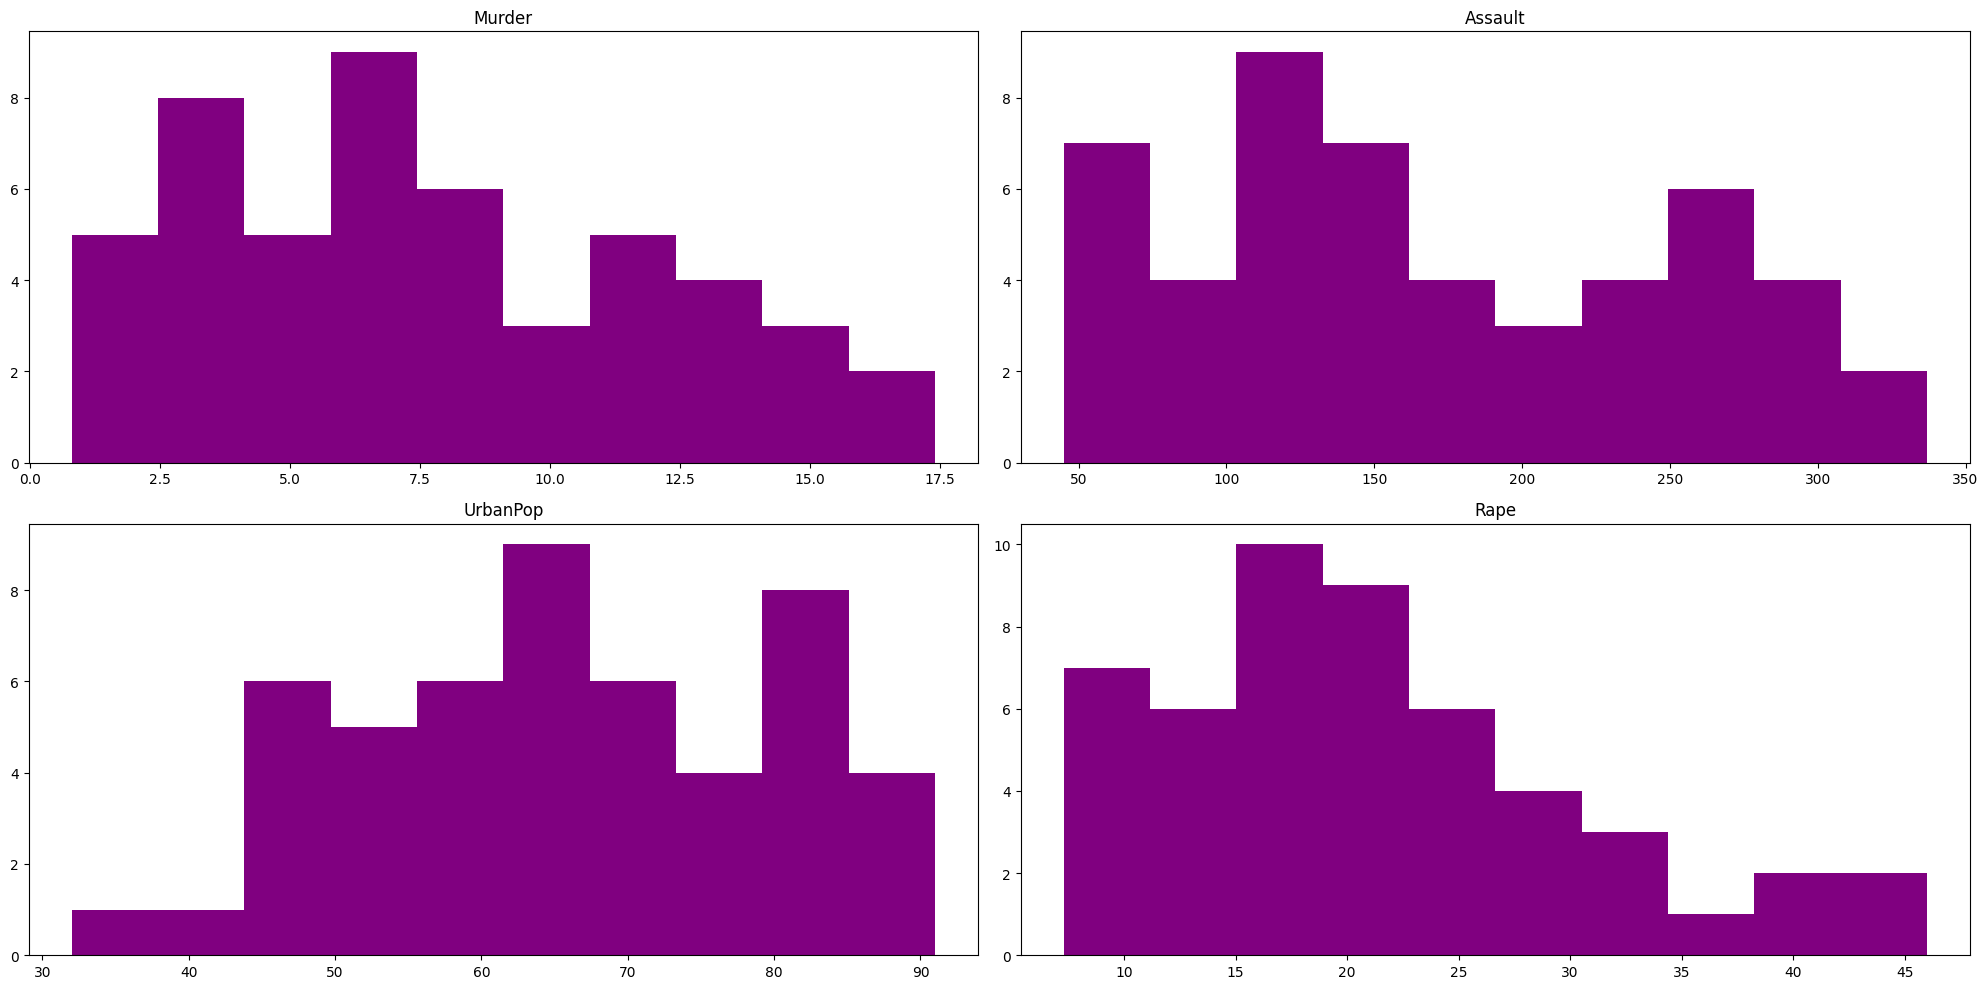

In [5]:
# Plot histograms
histograms = df.hist(color='purple', grid=False, figsize=(20, 10))
plt.tight_layout()
plt.show()

<AxesSubplot: title={'center': 'UrbanPop per City'}, xlabel='UrbanPop', ylabel='City'>

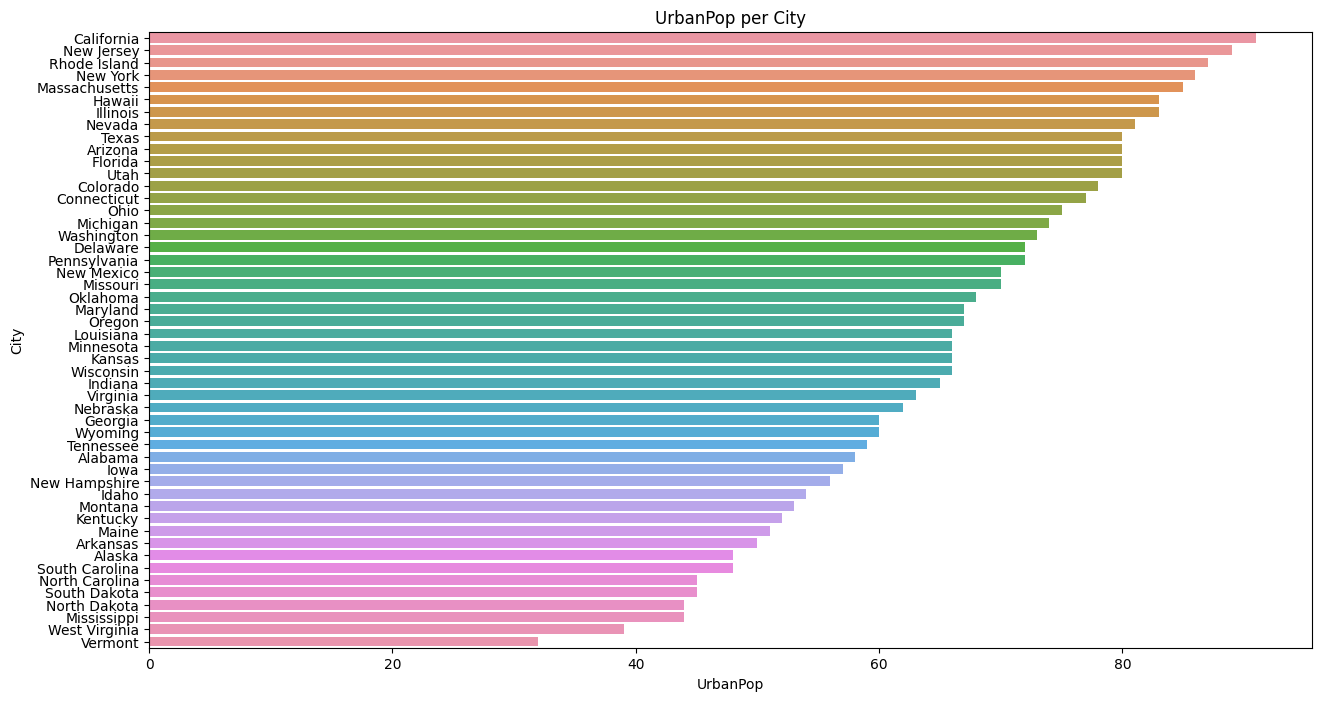

In [6]:
# Visualise UrbanPop by city
fig = plt.figure(figsize=(15,8))
plt.title("UrbanPop per City")
sns.barplot(data= df, x= "UrbanPop", y = "City", order = df.sort_values("UrbanPop", ascending = False).City)

The barplot above represents the urban population of each city, as shown et the top California and New Jersey are the biggest urban population cities, at the bottom Vermont and West Virginia are the smallest.

<AxesSubplot: title={'center': 'Assault rate per City'}, xlabel='Assault', ylabel='City'>

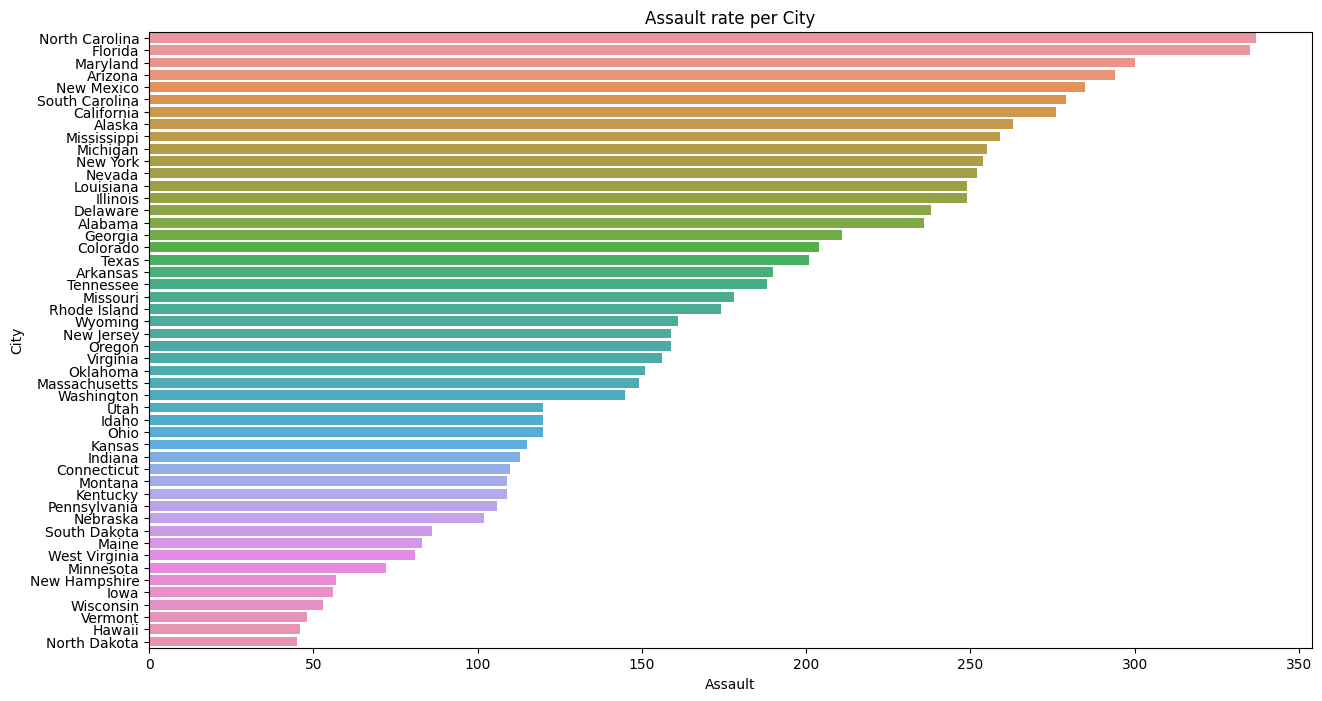

In [7]:
# Visualise Assault by city
fig = plt.figure(figsize=(15,8))
plt.title("Assault rate per City")
sns.barplot(data= df, x= "Assault", y = "City", order = df.sort_values("Assault", ascending = False).City)


The top three cities with a higher assault rate are North Carolina, Florida and Maryland.
At the bottom of the barplot, North Dakota, Hawaii and Vermon are safer considering variable assault and violence compared to other cities.

<AxesSubplot: title={'center': 'Murder rate per City'}, xlabel='Murder', ylabel='City'>

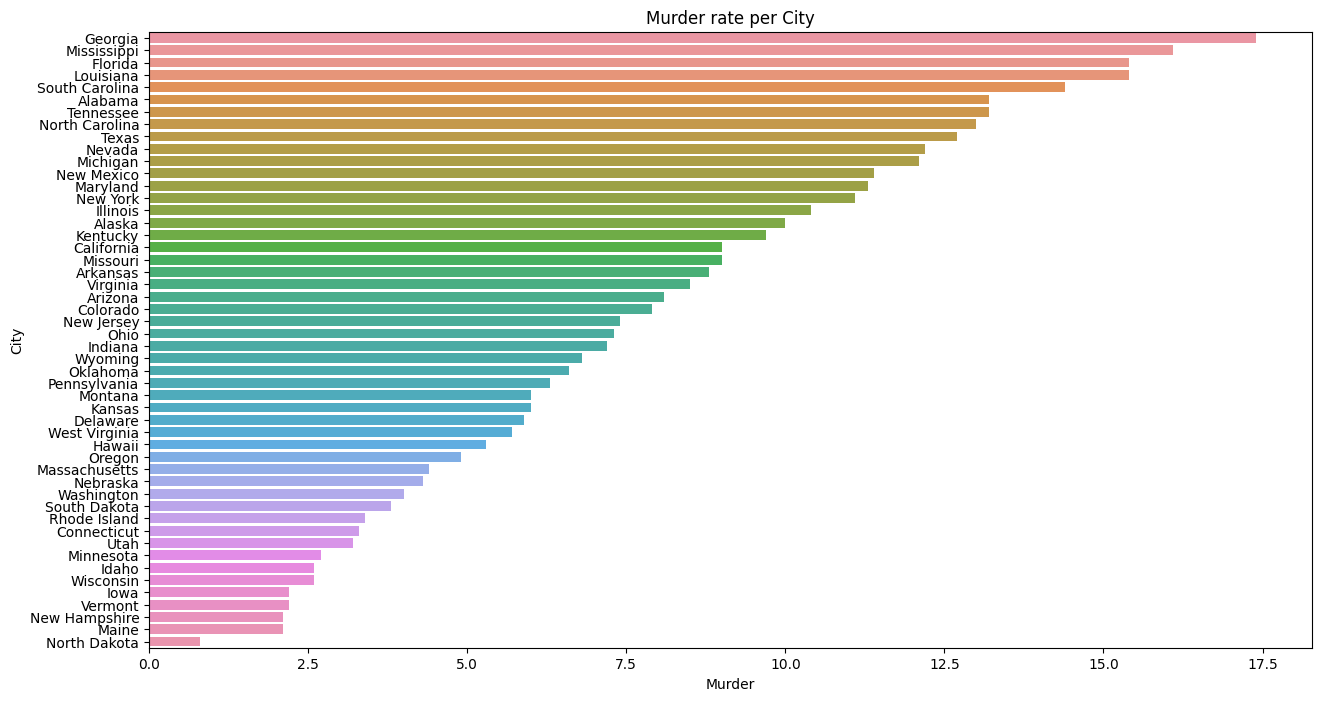

In [86]:
# Visualise Murder by city
fig = plt.figure(figsize=(15,8))
plt.title("Murder rate per City")
sns.barplot(data= df, x= "Murder", y = "City", order = df.sort_values("Murder", ascending = False).City)

The top three cities with a higher murder rate are Georgia, Mississippi and Florida.
At the bottom of the barplot, North Dakota, Main and New Hampshire are safer considering Murder compared to other cities.

<AxesSubplot: title={'center': 'Rape rate per City'}, xlabel='Rape', ylabel='City'>

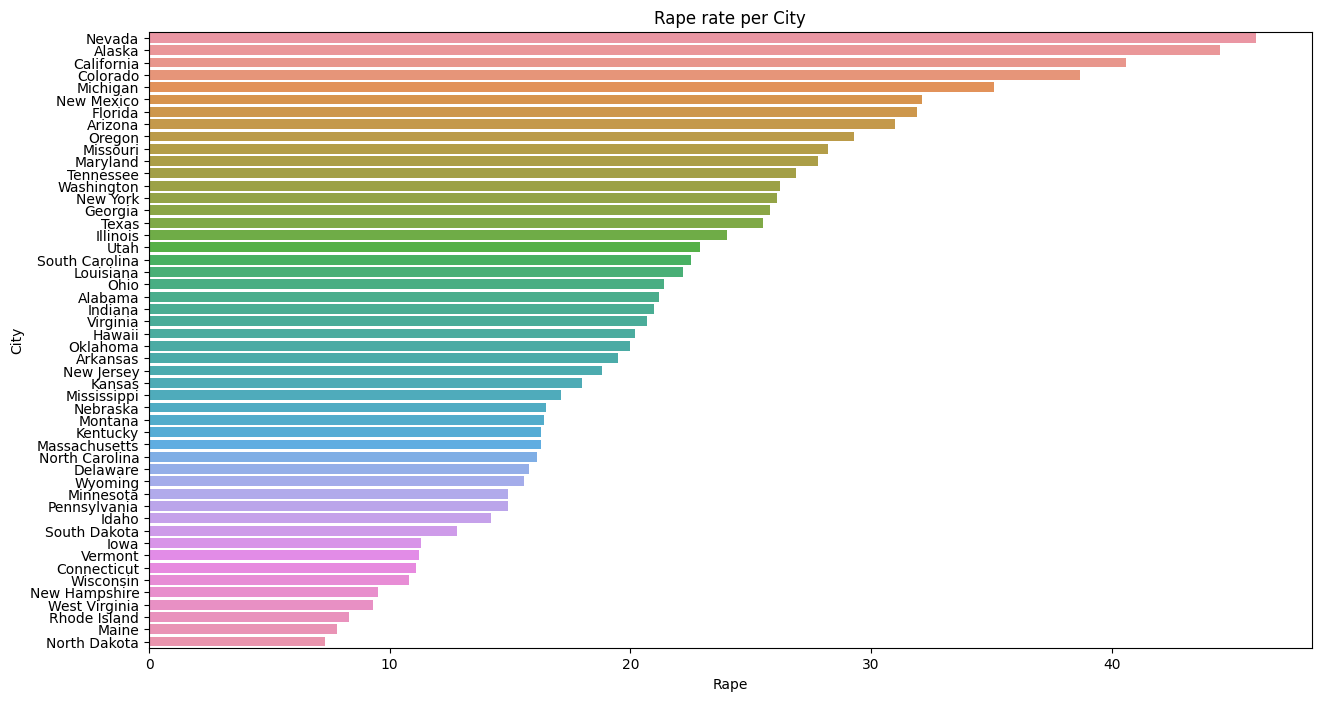

In [87]:
# Visualise Rape by city
fig = plt.figure(figsize=(15,8))
plt.title("Rape rate per City")
sns.barplot(data= df, x= "Rape", y = "City", order = df.sort_values("Rape", ascending = False).City)

Top three cities with a higher Rape rate are Nevada, Alaska and California.
At the bottom of the barplot, North Dakota, Main and Rhode Island are safer considering Rape comparing to other cities.

## Bivariate Analysis: Correlations

C:\Users\hnari\AppData\Local\Temp\ipykernel_13208\2932754812.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrs = df.corr()


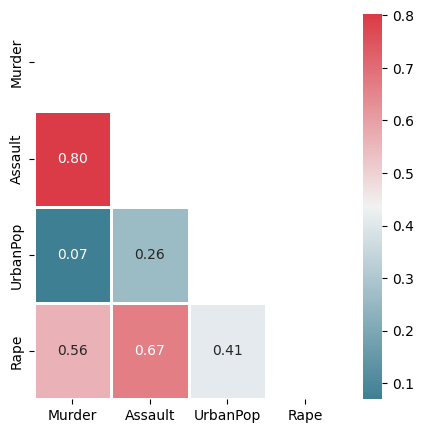

In [8]:
colormap = sns.diverging_palette(220, 10, as_cmap=True)

def corr_heatmap(df):
  # get correlations
  corrs = df.corr()

  # pick appropriate palette for heatmap

  # Plot figsize
  fig, ax = plt.subplots(figsize=(5, 5))

  # to mask mirrored side of heatmap
  dropSelf = np.zeros_like(corrs)
  dropSelf[np.triu_indices_from(dropSelf)] = True

  # Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
  ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)

  plt.show()

corr_heatmap(df)

From correlation matrix all correlations are positive , that means an increase in one variable corresponds to an increase in the other variable:
We can see that Assault is strongly correlated with Murder and Rape : those correlations are intuitive, people who commit a murder or  a rape need to act violantly toward their victims .


Murder and rape are also correlated in a lesser proportion.


On the other hand we have the Urbanpop variable which seems less correlation with all other variables: being a big or small city in urban population affects fairly/not on crime behaviours considered by the study.


# Apply PCA

Before applying PCA, we need to make some changes to our data frame, we will define the city as an index of the table frame first.
Also, PCA is largely affected by scales as our different features have different scales. So it is better to standardise data before finding PCA components.


In [12]:
#identify city variable as index of df dataframe:
df = df.set_index("City")

# standardize features
X = StandardScaler().fit_transform(df.values)

pca = PCA()

# obtain components
principal_comp = pca.fit_transform(X)

# transform the components into a pandas data frame
pca_df = pd.DataFrame(principal_comp, index=df.index)

print(pca_df)


                   0     1     2     3
City                                  
Alabama         0.99  1.13 -0.44  0.16
Alaska          1.95  1.07  2.04 -0.44
Arizona         1.76 -0.75  0.05 -0.83
Arkansas       -0.14  1.12  0.11 -0.18
California      2.52 -1.54  0.60 -0.34
Colorado        1.51 -0.99  1.10  0.00
Connecticut    -1.36 -1.09 -0.64 -0.12
Delaware        0.05 -0.33 -0.72 -0.88
Florida         3.01  0.04 -0.58 -0.10
Georgia         1.64  1.28 -0.34  1.08
Hawaii         -0.91 -1.57  0.05  0.90
Idaho          -1.64  0.21  0.26 -0.50
Illinois        1.38 -0.68 -0.68 -0.12
Indiana        -0.51 -0.15  0.23  0.42
Iowa           -2.25 -0.10  0.16  0.02
Kansas         -0.80 -0.27  0.03  0.21
Kentucky       -0.75  0.96 -0.03  0.67
Louisiana       1.56  0.87 -0.78  0.45
Maine          -2.40  0.38 -0.07 -0.33
Maryland        1.76  0.43 -0.16 -0.56
Massachusetts  -0.49 -1.47 -0.61 -0.18
Michigan        2.11 -0.16  0.38  0.10
Minnesota      -1.69 -0.63  0.15  0.07
Mississippi     1.00  2.3

## PCA model attribute plots
PCA components and their significance can be explained using following attributes

Explained variance is the amount of variance explained by each of the selected components. 

Explained variance ratio is the percentage of variance explained by each of the selected components.

Proportion of Variance Explained: [0.62006039 0.24744129 0.0891408  0.04335752]


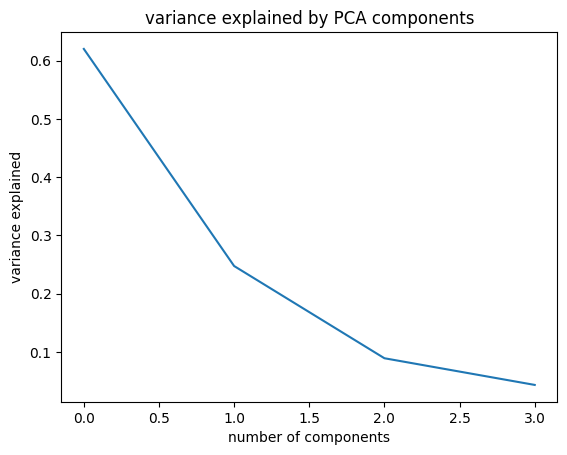

In [13]:
# variance explained by components
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

# Scree plot
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('variance explained')
plt.title("variance explained by PCA components")
plt.show()

Note: From the above plot, we can select our visualisations of data depending on important components or factors, and the elbow method combined with the “Kaiser-Guttman rule” is good to do so.

Cumulative Proportion: [2.53085875 3.5408232  3.90466318 4.08163265]


Text(0.5, 1.0, 'Cumulative Explained Variance')

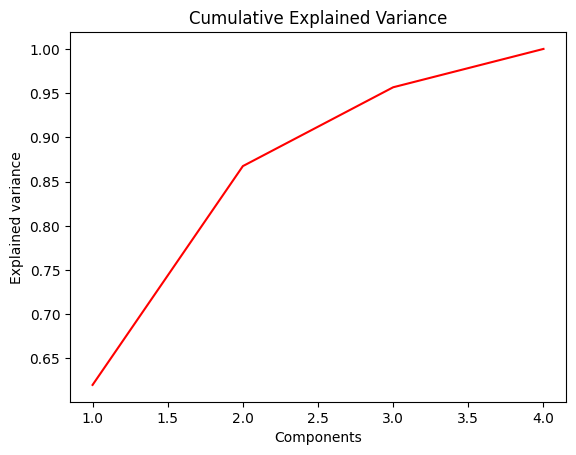

In [14]:
# cumulative variance explained 
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

From the PCA, we have 4 components to achieve 100% of variance explained of our data, the first component explains 62% and a second component explain around 25% (which makes 87% of cumulative variance explained as shown in the cumulative plot)
the third explains 9% and the last component explains 4% .


If we consider the 2 first components , the total variance explained will be 87% ,


If we consider the 3 first components , the total variance explained will be 96% which is a very good percentage of information.


Text(0.5, 1.0, 'variance explained = 87%')

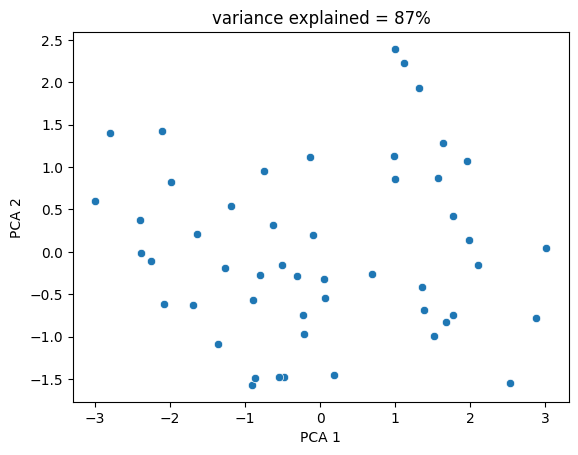

In [15]:
# visualise data in 2 diemtions (pca1 ,pca2)
sns.scatterplot(x=pca_df[0], y=pca_df[1])
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("variance explained = 87%")

From this scatter plot it is hard at first glance to spot any trend in our data, so we need first to find meaning to our factors (Components) and then come back to it.
We can explain our factors by analysing the effect of variables on each component.

# Effect of variables on each components

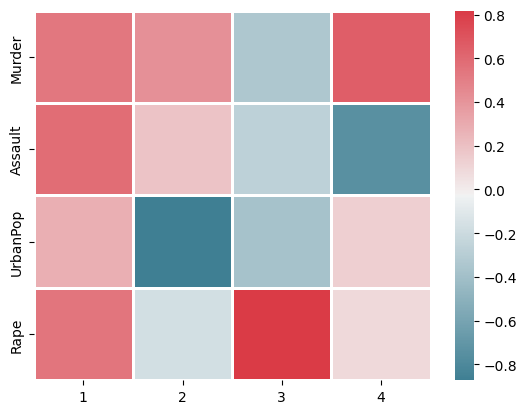

In [16]:
components = pd.DataFrame(pca.components_, columns= df.columns, index=range(1,5)).transpose()
ax = sns.heatmap(components,cmap=colormap,linewidth=1)
plt.show()


From the matrix above, the contribution of variables Assault, Murder and Rape to the construction of the first factor is clear with the heatmap effect, so we can explain that factor as a **crime factor**. so applying PCA helped to group the 3 features under 1 factor.


The second factor is strongly correlated with number of urban population **negatively**, so the rise in the positive side of factor (in space) we will find states with lower number of Urbanpop.


For the third and fourth factor, we can see that they are more affected by rape and Murder respectively.



# PCA Biplot
Biplot is an interesting plot and contains a lot of useful information.

It contains two plots:

PCA scatter plot which shows first two component ( We already plotted this above)
PCA loading plot which shows how strongly each characteristic influences a principal component.

In [17]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = df.index[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

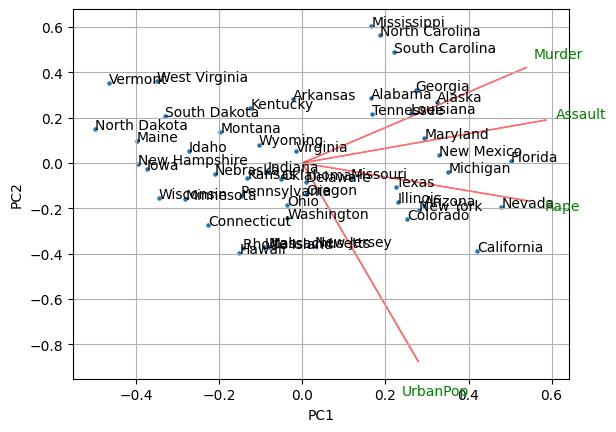

In [18]:
# apply biplot to our PCA 
biplot(principal_comp[:,0:2],np.transpose(pca.components_[0:2, :]),list(df.columns))
plt.show()

From the biplot, we use distance to explain the tendency between states and features.
Forexemple, Nevada is so close to Rape feature , that could be explain as higher Rape rate in the city of Nevada as well as all the cities close to Rape feature.


We know from matrix of contribution features on each component that PC1 is a crime factor, that mean all states in positive side of PC1 are closely linked to crime (Assault, Murder and Rape): Missisipi, North carolina, south carolina, Gorgia, Alabama, Alasca, .... to California.


Also there is a group of states that are positioned in the middle of the axis PC1 where crime is less higher than the first group,we can describe it as a middle/moderate crime group.


Finally, there is another group at the negative side of PC1, where crime is much less than the other groups.


Another important aspect to analyse PCA, is to find how well a data point (city or features) is represented in the 2 dimensions factorial plan. as some data points may be better represented in the PC1&PC3 plan or another factorial plan.
Note that's not our priority for now, the above analysis of Biplot was just to have a first insight of crime by states in the US,we will come back later to analyse which feature/features is/are more linked to a defined cluster.


One of the objectives of applying PCA was to reduce our dimensions and use principal components (as they are not correlated) with maximum explained variance to apply a clustering analysis.


## Hierarchical clustering


From PCA, if we consider the 3 first components , the total variance explained will be 96% -that's a great percentage of information to use for our next clustering models.


In [19]:
# define pc1 ,pc2, pc3

pca_clust = pd.DataFrame(principal_comp[:,0:3], index = pca_df.index)
pca_clust.head()

,0,1,2
City,,,
Alabama,0.99,1.13,-0.44
Alaska,1.95,1.07,2.04
Arizona,1.76,-0.75,0.05
Arkansas,-0.14,1.12,0.11
California,2.52,-1.54,0.60


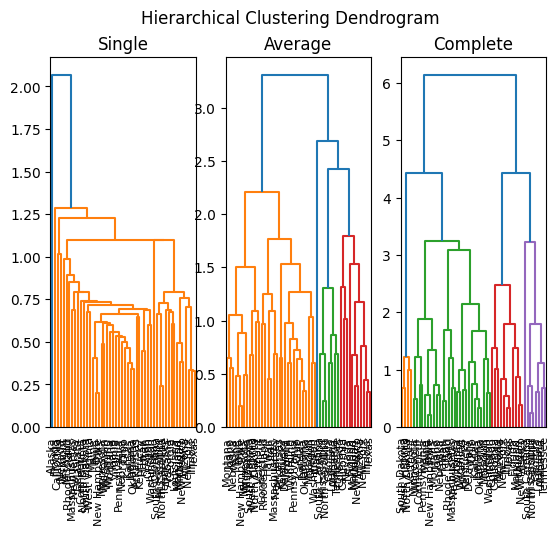

In [20]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_clust)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_clust, method='single'), labels=pca_clust.index, ax=ax1) 
ax2.set_title("Average")
dendrogram(linkage(pca_clust, method='average'), labels=pca_clust.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_clust, method='complete'), labels=pca_clust.index, ax=ax3)
plt.show()

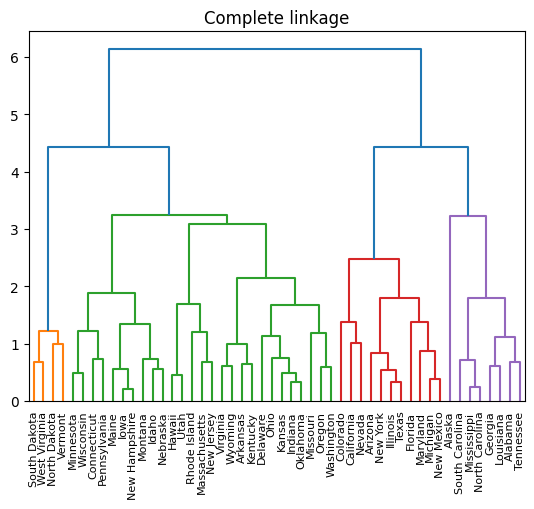

In [73]:
plt.title("Complete linkage")
dendrogram(linkage(pca_clust, method='complete'), labels=pca_clust.index)
plt.show()

# K-Means Clustering

From the complete linkage dendrogram, we have 4 different clusters.

Text(0, 0.5, 'Dim 1')

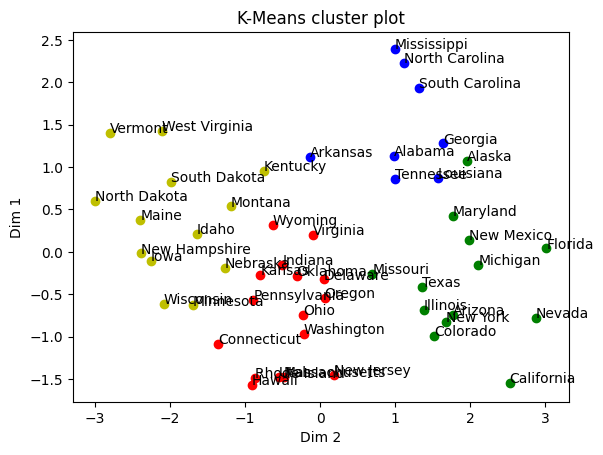

In [26]:
# We extract the first two components for plotting
x = principal_comp[:,0]
y = principal_comp[:,1]

# Fit k means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++',n_init="auto", random_state=42)
cluster_labels = kmeans.fit_predict(pca_clust)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = pca_clust.index[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")

In [27]:
#silhouette score
print(f"Silhouette K-mean 4 clusters = {round(silhouette_score(pca_clust, kmeans.labels_, metric='euclidean'),2)}")

Silhouette K-mean 4 clusters = 0.37


Comparing Sihouette between number of clusters 4 and 3 did not give a significant difference, but adding to the finding of PCA, we know that states with high crime are divided now into two different clusters, cluster linked more to Murder(in blue spot on the graph above) and cluster linked more to Rape crime(in green).
the states represented in red colour, the crime rate is lower compared to blue and green states.
Finally the states represented in yellow or light green are considered as the safest in the US, they are positioned at the opposit of Assault, Murder and Rape features from components factor plan, so the crime rate is very low.


In [28]:
# Groups - translate to readable names
group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]
group2_indices = np.argwhere(cluster_labels==2).transpose()[0]
group3_indices = np.argwhere(cluster_labels==3).transpose()[0]

group0 = np.array(pca_clust.index)[group0_indices]
group1 = np.array(pca_clust.index)[group1_indices]
group2 = np.array(pca_clust.index)[group2_indices]
group3 = np.array(pca_clust.index)[group3_indices]

print("Group 1: {}\n\n".format(group0))
print("Group 2: {}\n\n".format(group1))
print("Group 3: {}\n\n".format(group2))
print("Group 4: {}\n\n".format(group3))

Group 1: ['Connecticut' 'Delaware' 'Hawaii' 'Indiana' 'Kansas' 'Massachusetts'
 'New Jersey' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island'
 'Utah' 'Virginia' 'Washington' 'Wyoming']


Group 2: ['Alabama' 'Arkansas' 'Georgia' 'Louisiana' 'Mississippi' 'North Carolina'
 'South Carolina' 'Tennessee']


Group 3: ['Alaska' 'Arizona' 'California' 'Colorado' 'Florida' 'Illinois'
 'Maryland' 'Michigan' 'Missouri' 'Nevada' 'New Mexico' 'New York' 'Texas']


Group 4: ['Idaho' 'Iowa' 'Kentucky' 'Maine' 'Minnesota' 'Montana' 'Nebraska'
 'New Hampshire' 'North Dakota' 'South Dakota' 'Vermont' 'West Virginia'
 'Wisconsin']




# **Conclusion**
As conclusion, We can classify the 50 States of US regarding crime behaviour into four different groups:




**Group1:**
 Represented in red colour, including ['Connecticut' 'Delaware' 'Hawaii' 'Indiana' 'Kansas' 'Massachusetts'
'New Jersey' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island'
'Utah' 'Virginia' 'Washington' 'Wyoming']


Description: Low to Middle crime rate.




**Group2:**
 Represented in blue colour,including ['Alabama' 'Arkansas' 'Georgia' 'Louisiana' 'Mississippi' 'North Carolina'
'South Carolina' 'Tennessee']


Description: High crime rate, linked more to Murder & Assault.




**Group3:**
 Represented in green colour,  including ['Alaska' 'Arizona' 'California' 'Colorado' 'Florida' 'Illinois'
'Maryland' 'Michigan' 'Missouri' 'Nevada' 'New Mexico' 'New York' 'Texas']


Description: High crime rate, linked more to Rape & Assault.



**Group4:**
 Represented in yellow colour, including  ['Idaho' 'Iowa' 'Kentucky' 'Maine' 'Minnesota' 'Montana' 'Nebraska'
'New Hampshire' 'North Dakota' 'South Dakota' 'Vermont' 'West Virginia'
'Wisconsin']

Description: The safest states in the US, Very low crime rate.

In [ ]:
# HyperionDev/Data Science Bootcamp/Final Capston Project

# Data set: UsArrests.csv from Kaggle

# Author: Narimen HB